# Characterization interconnected patterns

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

### Let us import an image and make it binary.

In [2]:
from skimage import io, exposure, restoration, img_as_ubyte

file_name =os.path.expanduser("~/Documents/DATA/Segmentation/spinodal_test_SVI.tif")
im_scale = io.imread(file_name, as_gray=True)
ima = img_as_ubyte(im_scale[20:940])


### Step 1 : denoising

In [ ]:
im = exposure.equalize_adapthist(ima)
im_tv = restoration.denoise_tv_bregman(im, 0.1)

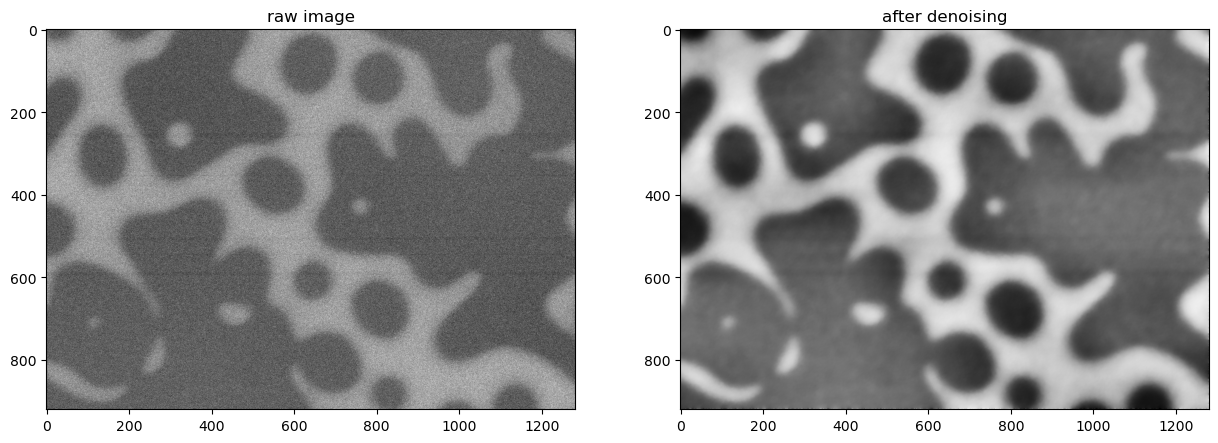

In [4]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
ax1,ax2=axs
ax1.imshow(ima, cmap='gray')
ax1.title.set_text('raw image')
ax2.imshow(im_tv, cmap='gray')
ax2.title.set_text('after denoising')

### Step 2: process segmentation, by Otsu tresholding.

In [5]:
from skimage import segmentation, measure, morphology, draw, filters
from skimage.measure import label
from skimage.color import label2rgb


In [ ]:

im_bin = im_tv > filters.threshold_otsu(im_tv)
im_bin = morphology.remove_small_objects(im_bin, 10)
im_bin_perco = morphology.remove_small_objects(im_bin, 10000)
im_bin_drop = np.logical_xor(im_bin, im_bin_perco)

### Step 3: add labels.

In [ ]:
im_label = measure.label(im_bin)
im_label_perco = measure.label(im_bin_perco)
im_lab = label2rgb(im_label, im_tv)

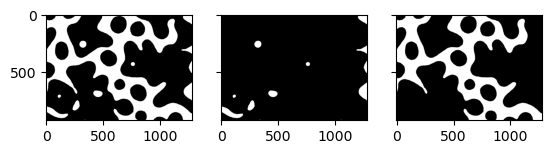

In [7]:
fig, axs = plt.subplots(ncols=3, sharex=1, sharey=1)
for ax, im in zip(axs.ravel(), [im_bin, im_bin_drop, im_bin_perco]):
    ax.imshow(im, cmap="afmhot")

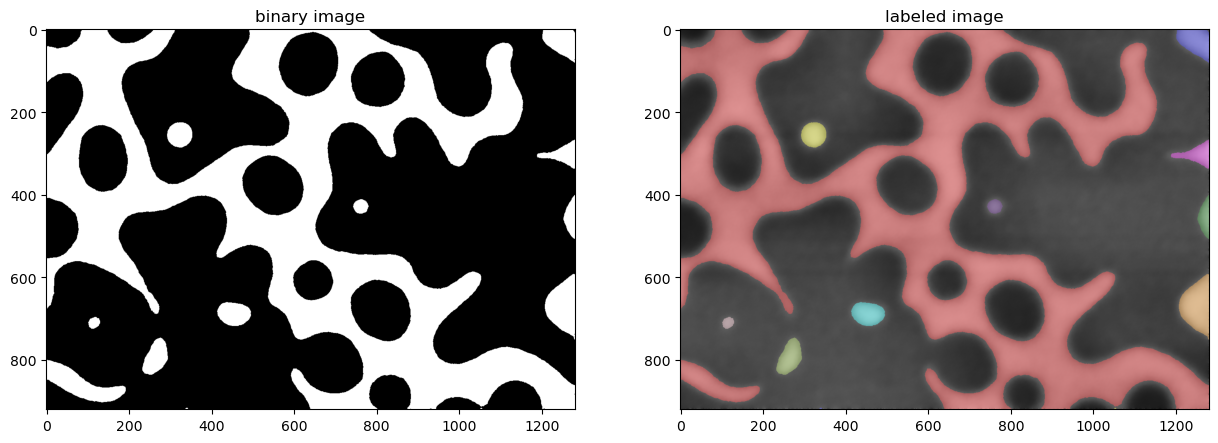

In [8]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
ax1,ax2=axs
ax1.imshow(im_bin, cmap='gray')
ax1.title.set_text('binary image')
ax2.imshow(im_lab)
ax2.title.set_text('labeled image')

### A fisrt typical lengthscale can be obtained as the ratio of area/perimeter.
<details>
    <summary>  
        <b>Note:</b>  
    </summary>  
Not sure what this gives tough
</details>


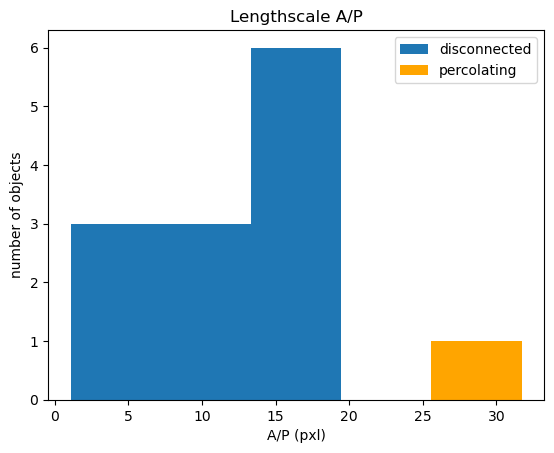

In [11]:
properties=measure.regionprops(im_label)
area = []
perimeter = []
for prop in properties:
    area.append(prop.area)
    perimeter.append(prop.perimeter)
lenghtscale = np.asarray(area)/np.asarray(perimeter)

properties_perco=measure.regionprops(im_label_perco)
area_perco = []
perimeter_perco = []
for prop in properties_perco:
    area_perco.append(prop.area)
    perimeter_perco.append(prop.perimeter)
lenghtscale_perco = np.asarray(area_perco)/np.asarray(perimeter_perco)

plt.xlabel('A/P (pxl)')
plt.ylabel('number of objects')
plt.title('Lengthscale A/P')
n,bins, patch =plt.hist(lenghtscale, bins='auto', label='disconnected')
_=plt.hist(lenghtscale_perco, bins=bins, color='orange', label='percolating')
plt.legend();

> So, we can distinguish the percolating phase (caractristic lenght of 30px) and the disconnected phase (15px)

### Skeletonization + distances
We can think about a second typical length as the width of the wormlike part. It can be studied by skeletonization of the connected phase, and measure of the minimal distance to edges.

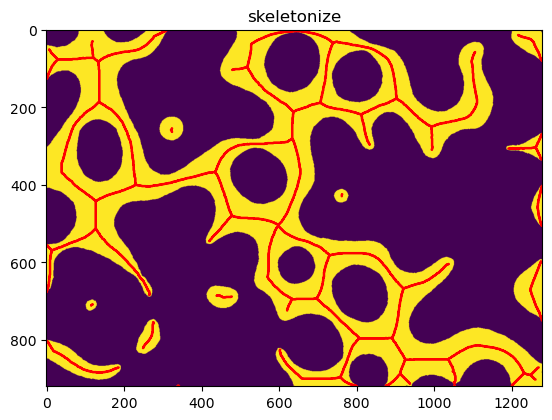

In [12]:
skel = morphology.skeletonize(im_bin_drop)
skel_perco = morphology.skeletonize(im_bin_perco)

plt.title('skeletonize')
plt.imshow(im_bin)
plt.contour(skel, colors='r')
plt.contour(skel_perco, colors='r');

In [ ]:
from scipy import ndimage

mat_skel=ndimage.distance_transform_edt(im_bin)

In [26]:
d_skel = []
d_skel_perco = []

d_skel_arr = np.zeros_like(im_bin)
d_skel_perco_arr = np.zeros_like(im_bin)

for i in range (0, np.shape(skel)[0]):
    for j in range (0, np.shape(skel)[1]):
        if (skel[i][j]==True):
            d_skel.append(0.5+mat_skel[i][j]) # à chaque pixel de skeleton, attribuer la distance jusqu'à le background
            d_skel_arr[i, j] = 0.5+mat_skel[i][j]
        if (skel_perco[i][j]==True):
            d_skel_perco.append(0.5+mat_skel[i][j])
            d_skel_perco_arr[i, j] = 0.5+mat_skel[i][j]

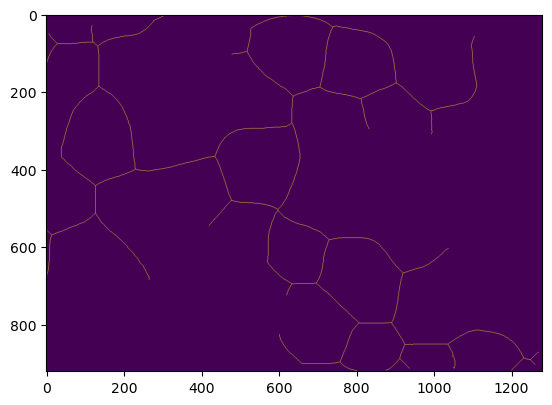

In [29]:
plt.imshow(d_skel_perco_arr)

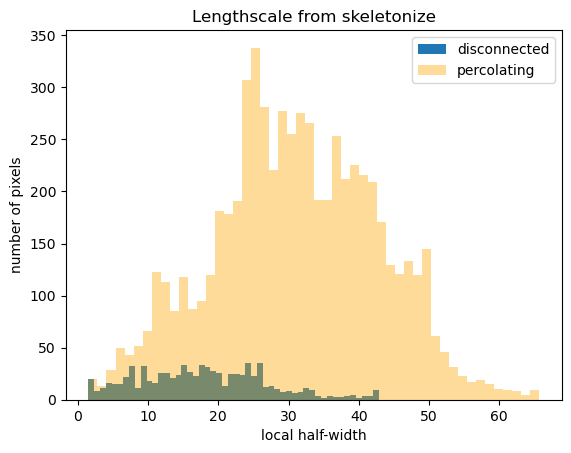

In [31]:
bins=50
plt.xlabel('local half-width')
plt.ylabel('number of pixels')
plt.title('Lengthscale from skeletonize')
_ =plt.hist(d_skel, bins=bins, label='disconnected')
_ =plt.hist(d_skel_perco, bins=bins, color='orange', alpha=.4, label='percolating')
plt.legend();